# Import Packages

In [2]:
# import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# import custom code written for this project
from modules import *

# import RDKit
from rdkit import Chem

# import and check funtionality of pytorch
import torch
print("Pytorch version = ", torch.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.12.1
CUDA version =  None
CUDA available =  False
Random Pytorch test tensor =  tensor([0.5610])


# Load and Prepare Data

In [3]:
# initialise dictionary used to store experimental settings, after dictionary is initialised, choose one of the five data sets below to proceed

settings_dict = {}

In [4]:
# LIT-PCBA Estrogen Receptor Alpha Antagonism

settings_dict["dataset_name"] = "lit_pcba_esr_ant"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [5]:
# MoleculeNet Lipophilicity

settings_dict["dataset_name"] = "moleculenet_lipophilicity"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "exp"

In [6]:
# AqSolDB solubility

settings_dict["dataset_name"] = "aqsoldb_solubility"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "Solubility"

In [7]:
# PostEra SARS-CoV-2 Mpro inhibition

settings_dict["dataset_name"] = "postera_sars_cov_2_mpro"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "f_avg_IC50"

In [8]:
# Ames mutagenicity

settings_dict["dataset_name"] = "ames_mutagenicity"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [9]:
# load clean data

dataframe = pd.read_csv("data/" + settings_dict["dataset_name"] + "/" + "clean_data.csv", sep = ",")
display(dataframe)

,SMILES,Activity
0,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
1,CC(=O)OC1(C(C)=O)CCC2C3C=C(Cl)C4=CC(=O)OCC4(C)...,0
2,Nc1nc(N)nc(N)n1,0
3,Cc1ccc(N=Nc2c(O)ccc3ccccc23)c([N+](=O)[O-])c1,1
4,CC(C)CC(=O)Nc1c2ccccc2ns1,0
...,...,...
6500,COC1COC(COCC2COC(OC)C(OS(=O)(=O)O)C2OS(=O)(=O)...,0
6501,O=Nn1cc(CC(O)C(=O)O)c2ccccc21,1
6502,COC(=O)Nc1nc2ccccc2[nH]1,1
6503,ClCc1cccc2c1-c1cccc3cccc-2c13,1


Mean Value (Target) =  0.5374327440430439
Standard Deviation (Target) =  0.4985968207614324
Maximum Value (Target) =  1.0
Minimum Value (Target) =  0.0 

Shape of y =  (6505,)

 y =  [0. 0. 0. ... 1. 1. 1.]


(array([3009.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3496.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

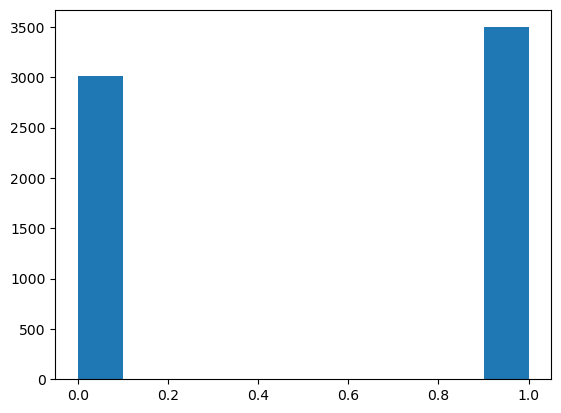

In [10]:
# construct target variable y (for the SARS-CoV-2 main protease data set, we convert Ki to pKi by taking negative decadic logarithm)

if settings_dict["dataset_name"] == "postera_sars_cov_2_mpro":
    y = -np.log10(dataframe.loc[:, settings_dict["prop_name"]].values.astype(float))
else:
    y = dataframe.loc[:, settings_dict["prop_name"]].values.astype(float)

print("Mean Value (Target) = ", np.mean(y))
print("Standard Deviation (Target) = ", np.std(y))
print("Maximum Value (Target) = ", np.amax(y))
print("Minimum Value (Target) = ", np.amin(y), "\n")

print("Shape of y = ", y.shape)
print("\n y = ", y)

plt.hist(y)

Shape of x_smiles =  (6505,)
O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c5c(=O)c6ccccc6c(=O)c5ccc4c3c12


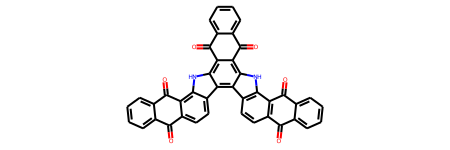

In [11]:
# extract SMILES strings

x_smiles = np.reshape(dataframe["SMILES"].values, (len(dataframe), 1))[:,0]

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

In [12]:
# create dictionary that maps smiles strings to their target values

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))

# Prepare Data Split

In [13]:
# choose settings for dictionary that contains indices for data splits

settings_dict["split_type"] = "rand" # choose "rand" for random split and "scaff" for scaffold split
settings_dict["split_type_rand_stratified"] = False # given a random split and a classification problem, choose whether to stratify the split
settings_dict["k_splits"] = 2 # choose number of cross validation folds k_splits
settings_dict["m_reps"] = 3 # choose number of random seeds m_reps with which the cross validation scheme is repeated
settings_dict["random_state_cv"] = 42 # choose random state

In [14]:
# construct dictionary that contains indices for data splits

if settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == False:
    
    data_split_dict = create_data_split_dict_random(x_smiles = x_smiles,
                                                    k_splits = settings_dict["k_splits"],
                                                    m_reps = settings_dict["m_reps"],
                                                    random_state_cv = settings_dict["random_state_cv"])

elif settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == True:
    
    data_split_dict = create_data_split_dict_random_strat(x_smiles = x_smiles,
                                                          y = y,
                                                          k_splits = settings_dict["k_splits"],
                                                          m_reps = settings_dict["m_reps"],
                                                          random_state_cv = settings_dict["random_state_cv"])
    
elif settings_dict["split_type"] == "scaff":
    
    data_split_dict = create_data_split_dict_scaffold(x_smiles = x_smiles,
                                                      k_splits = settings_dict["k_splits"],
                                                      m_reps = settings_dict["m_reps"],
                                                      scaffold_func = "Bemis_Murcko_generic",
                                                      random_state_cv = settings_dict["random_state_cv"])

# Evaluate Models

In [15]:
# choose ECFP hyperparameters

settings_dict["ecfp_settings"] = {"mol_to_invs_function": ecfp_invariants, # ecfp_invariants or fcfp_invariants
                                  "radius": 2, # 0 or 1 or 2 or 3 ...
                                  "pool_method": "sort_and_slice", # "hashed" or "sort_and_slice" or "filtered" or "mim"
                                  "dimension": 1024, # 256 or 512 or 1024 or 2048 or 4096 ...
                                  "use_bond_invs": True, # True or False
                                  "use_chirality": True, # True or False
                                  "use_counts": False} # True or False

In [16]:
# chose ml model: random forest or multilayer perceptron

settings_dict["ml_model"] = "rf" # "rf" or "mlp"

In [17]:
# choose rf hyperparameters

settings_dict["rf_settings"] = {"n_estimators" : 100,
                                "max_depth" : None,
                                "min_samples_leaf" : 1,
                                "min_samples_split" : 2,
                                "bootstrap" : True,
                                "max_features": "sqrt",
                                "random_state" : 42}

if settings_dict["task_type"] == "regression":

    settings_dict["rf_settings"]["criterion"] = "squared_error"

elif settings_dict["task_type"] == "classification":

    settings_dict["rf_settings"]["criterion"] = "gini"

In [18]:
# choose mlp hyperparameters

settings_dict["mlp_settings"] = {"architecture" : list(arch(settings_dict["ecfp_settings"]["dimension"], 1, 512, 5)),
                                "hidden_activation" : torch.nn.ReLU(),
                                "use_bias" : True,
                                "hidden_dropout_rate" : 0.25,
                                "hidden_batchnorm" : True,
                                "batch_size" : 64,
                                "dataloader_shuffle" : True,
                                "dataloader_drop_last" : True,
                                "learning_rate" : 1e-3,
                                "lr_lambda" : lambda epoch: max(0.98**epoch, 1e-2),
                                "lr_last_epoch": 0,
                                "weight_decay" : 0.1,
                                "num_epochs" : 250,
                                "optimiser" : torch.optim.AdamW,
                                "print_results_per_epochs" : None}

if settings_dict["task_type"] == "regression":

    settings_dict["mlp_settings"]["output_activation"] = torch.nn.Identity()
    settings_dict["mlp_settings"]["loss_function"] = torch.nn.MSELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "regression"

elif settings_dict["task_type"] == "classification":

    settings_dict["mlp_settings"]["output_activation"] = torch.nn.Sigmoid()
    settings_dict["mlp_settings"]["loss_function"] = torch.nn.BCELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "classification"

In [26]:
# ECFP

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                        x_smiles_train = x_smiles[ind_train], 
                                        y_train = y[ind_train], 
                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,
                                        base = 2, 
                                        random_state = 42)
    
    # create ecfp-based feature matrices
    X_train = featuriser(x_smiles[ind_train])
    X_test = featuriser(x_smiles[ind_test])

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        rf_model.fit(X_train, y[ind_train])
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

Number of unique circular substructures with specified parameters in molecular training data set =  13958
0 0


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Scores:,0.88582,0.872391,0.802029,0.800317,0.817253,0.601379,0.822857,0.777778,0.811725,0.790399,3253.0,1503.0,1750.0


Number of unique circular substructures with specified parameters in molecular training data set =  13711
0 1


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Scores:,0.878417,0.863168,0.787823,0.787345,0.800693,0.574004,0.793814,0.780876,0.807692,0.765625,3252.0,1506.0,1746.0


Number of unique circular substructures with specified parameters in molecular training data set =  13935
1 0


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Scores:,0.881623,0.864254,0.790655,0.789542,0.804479,0.57921,0.805635,0.773448,0.803326,0.776011,3253.0,1514.0,1739.0


Number of unique circular substructures with specified parameters in molecular training data set =  13894
1 1


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Scores:,0.884355,0.870781,0.800123,0.798767,0.815131,0.597595,0.815595,0.78194,0.814667,0.782987,3252.0,1495.0,1757.0


Number of unique circular substructures with specified parameters in molecular training data set =  14058
2 0


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Scores:,0.879205,0.864844,0.784814,0.783798,0.798619,0.567596,0.798619,0.768977,0.798619,0.768977,3253.0,1515.0,1738.0


Number of unique circular substructures with specified parameters in molecular training data set =  13574
2 1


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Scores:,0.879462,0.864771,0.79059,0.790432,0.803577,0.579704,0.792378,0.788487,0.815097,0.763448,3252.0,1494.0,1758.0


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.885820,0.872391,0.802029,0.800317,0.817253,0.601379,0.822857,0.777778,0.811725,0.790399,3253.0,1503.000000,1750.000000
"(0, 1)",0.878417,0.863168,0.787823,0.787345,0.800693,0.574004,0.793814,0.780876,0.807692,0.765625,3252.0,1506.000000,1746.000000
"(1, 0)",0.881623,0.864254,0.790655,0.789542,0.804479,0.579210,0.805635,0.773448,0.803326,0.776011,3253.0,1514.000000,1739.000000
"(1, 1)",0.884355,0.870781,0.800123,0.798767,0.815131,0.597595,0.815595,0.781940,0.814667,0.782987,3252.0,1495.000000,1757.000000
"(2, 0)",0.879205,0.864844,0.784814,0.783798,0.798619,0.567596,0.798619,0.768977,0.798619,0.768977,3253.0,1515.000000,1738.000000
"(2, 1)",0.879462,0.864771,0.790590,0.790432,0.803577,0.579704,0.792378,0.788487,0.815097,0.763448,3252.0,1494.000000,1758.000000
mean,0.881480,0.866702,0.792672,0.791700,0.806625,0.583248,0.804816,0.778584,0.808521,0.774574,3252.5,1504.500000,1748.000000
std,0.002762,0.003528,0.006281,0.005942,0.007053,0.012206,0.011229,0.006244,0.006014,0.009648,0.5,8.220908,7.852813


FileNotFoundError: [Errno 2] No such file or directory: 'results/ames_mutagenicity/rand/ames_mutagenicity_randk2m3_1024ecfp4sort_and_slice_rf.csv'

In [19]:
settings_dict["ml_model"] = "rf" # "rf" or "mlp"

In [20]:
# E3fp

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    featuriser = create_e3fp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                        x_smiles_train = x_smiles[ind_train], 
                                        y_train = y[ind_train], 
                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,
                                        base = 2, 
                                        random_state = 42)
    
    # create ecfp-based feature matrices
    X_train = featuriser(x_smiles[ind_train])
    X_test = featuriser(x_smiles[ind_test])

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        rf_model.fit(X_train, y[ind_train])
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

2025-01-27 11:41:33,611|INFO|Generating fingerprints for O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c5c(=O)c6ccccc6c(=O)c5ccc4c3c12.
2025-01-27 11:41:33,613|ERROR|Error generating fingerprints for O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c5c(=O)c6ccccc6c(=O)c5ccc4c3c12.
Traceback (most recent call last):
  File "/mnt/data/slurm-storage/aruraj/psi4conda/envs/ecfp_substructure_pooling/lib/python3.7/site-packages/e3fp/fingerprint/generate.py", line 202, in fprints_dict_from_mol
    "Generated {:d} fingerprints for {!s}.".format(j + 1, name)
UnboundLocalError: local variable 'j' referenced before assignment


ValueError: max() arg is an empty sequence

In [19]:
%%time
# run full battery of experiments for one data set and data splitting type with both rfs and mlps

# first clear folder from previous experimental results
delete_all_files_in_folder("results/" + settings_dict["dataset_name"] + "/" + settings_dict["split_type"] + "/")

for pool_method in ["hashed", "filtered", "mim", "sort_and_slice"]:
    for dimension in [512, 1024, 2048, 4096]:
        for inv_func in [ecfp_invariants, fcfp_invariants]:
            for radius in [1, 2, 3]:

                print("pool_method = ", pool_method)
                print("dimension = ", dimension)
                print("inv_func = ", inv_func)
                print("radius = ", radius, "\n")

                # choose ECFP hyperparameters
                settings_dict["ecfp_settings"] = {"mol_to_invs_function": inv_func,
                                                  "radius": radius,
                                                  "pool_method": pool_method,
                                                  "dimension": dimension,
                                                  "use_bond_invs": True,
                                                  "use_chirality": True,
                                                  "use_counts": False}

                # run rf- and mlp models and save results
                scores_dict_rf = {}
                scores_dict_mlp = {}

                # ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
                for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
                    
                    # create ecfp featuriser
                    featuriser = create_e3fp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                                        x_smiles_train = x_smiles[ind_train], 
                                                        y_train = y[ind_train], 
                                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,  
                                                        base = 2, 
                                                        random_state = 42)

                    # create ecfp-based feature matrices
                    X_train = featuriser(x_smiles[ind_train])
                    X_test = featuriser(x_smiles[ind_test])
                    
                    # create rf model + train ml model + make predictions on test set
                    rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
                    rf_model.fit(X_train, y[ind_train])
                    y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])

                    # record rf scores
                    print(m, k, "rf")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_rf[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_rf[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False)
                    
                    # create mlp model + train ml model + make predictions on test set
                    settings_dict["mlp_settings"]["architecture"][0] = dimension
                    mlp_model = create_mlp_model(settings_dict["mlp_settings"])
                    (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
                    y_test_pred = make_mlp_prediction(mlp_model, X_test)

                    # record mlp scores
                    print(m, k, "mlp")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_mlp[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_mlp[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False) 
                    
                # summarise, display and save scores for this experiment
                settings_dict["ml_model"] = "rf"
                summarise_display_and_save_results_and_settings(scores_dict_rf, settings_dict, display_results = True)
                settings_dict["ml_model"] = "mlp"
                summarise_display_and_save_results_and_settings(scores_dict_mlp, settings_dict, display_results = True)
                print("\n \n \n")

pool_method =  hashed
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fa82291ac20>
radius =  1 



0 0 rf


KeyboardInterrupt: 

# Visualisation of Results

Dataset names:

    "ames_mutagenicity",
    "aqsoldb_solubility",
    "lit_pcba_esr_ant",
    "moleculenet_lipophilicity",
    "postera_sars_cov_2_mpro".
    
Available classification metrics: 

    "PRC-AUC",
    "AUROC", 
    "Accuracy", 
    "Balanced Accuracy", 
    "F1-Score", 
    "MCC", 
    "Sensitivity", 
    "Specificity", 
    "Precision", 
    "Negative Predictive Value", 
    "Test Cases", 
    "Negative Test Cases", 
    "Positive Test Cases".

Available regression metrics:

    "MAE", 
    "MedAE", 
    "RMSE", 
    "MaxAE", 
    "MSE", 
    "PearsonCorr", 
    "R2Coeff", 
    "Test Cases".

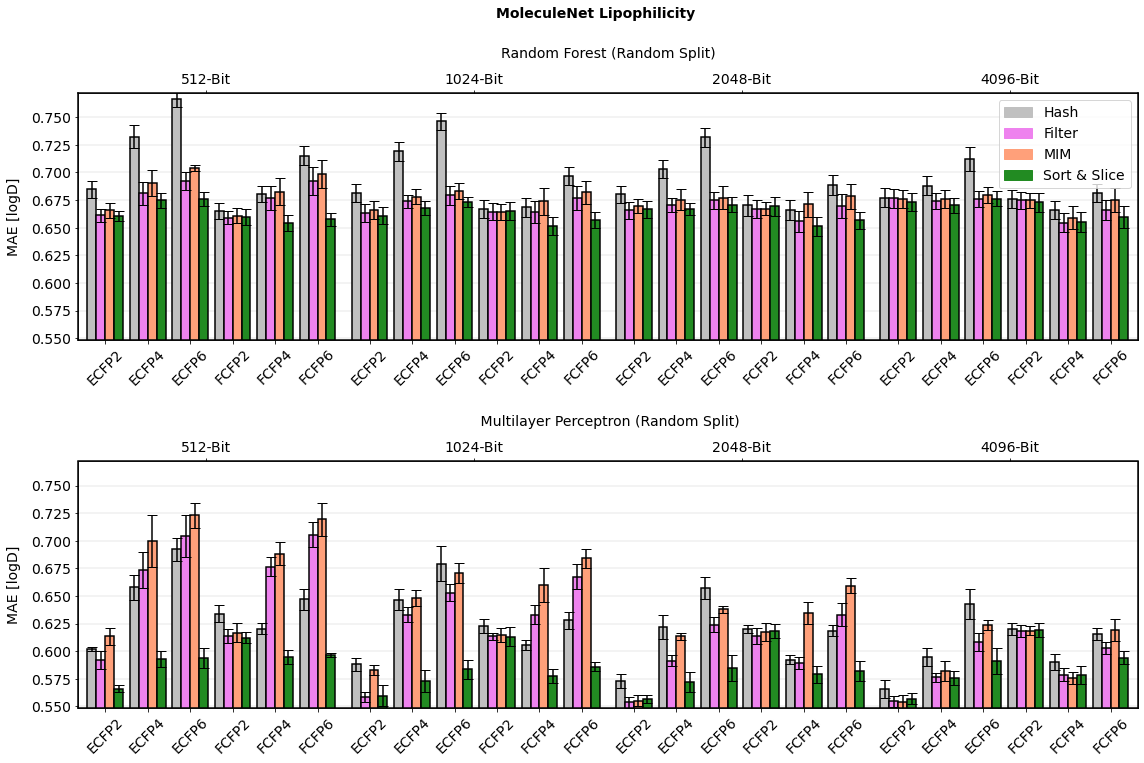

In [8]:
visualise_bar_charts(dataset_name = "moleculenet_lipophilicity", # specify dataset name
                     split_type = "rand", # specify split type "rand" or "scaff" (for random or scaffold split)
                     metric = "MAE", # specify performance metric,
                     y_lims = None, # specify limits of y-axis (set to "None" for automatic limits)
                     y_unit = " [logD]") # specify unit for y-axis (if applicable)

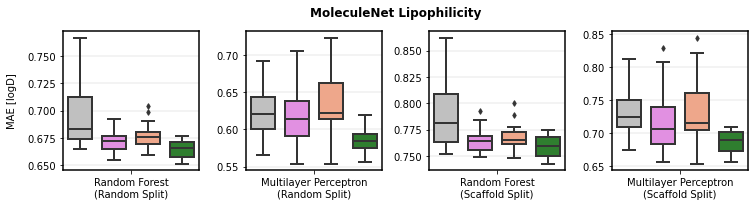

In [10]:
visualise_box_plots(dataset_name = "moleculenet_lipophilicity", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = " [logD]", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not